In [9]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import html
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [10]:
df_train = pd.read_csv("train.tsv", sep="\t", header =None , names=["hate_score","offensive_score", "text"])
df_train.head()

,hate_score,offensive_score,text
0,0,0,"Alarm set, early bird n all that. Night all xx"
1,1,2,@EvanBecker513 @_TriggaPlease_ @MorbidMermaid ...
2,0,3,RT @_MindAtEase: Wet pussy with no smell a mf
3,0,3,RT @itsSamCollins: I hate seeing people with m...
4,0,3,&#8220;@RawrItsTaraa: Trust these bitches ? Na...


In [11]:
df_train.shape

(19826, 3)

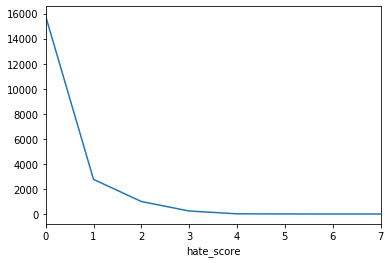

In [12]:
%matplotlib inline
df_train.groupby("hate_score").count()['text'].plot()

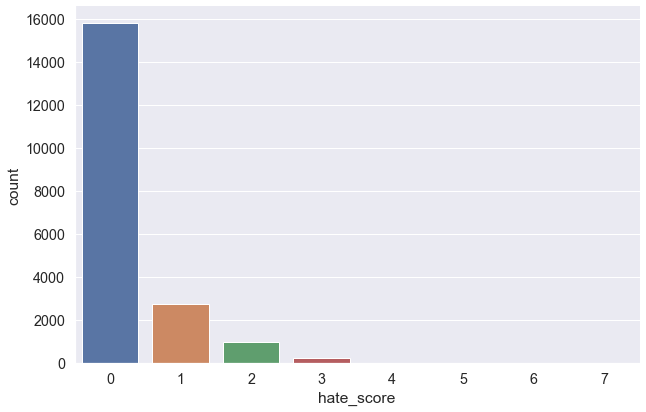

In [98]:
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
sns.catplot(x="hate_score", data=df_train, kind="count", height=6, aspect=1.5)
plt.show();

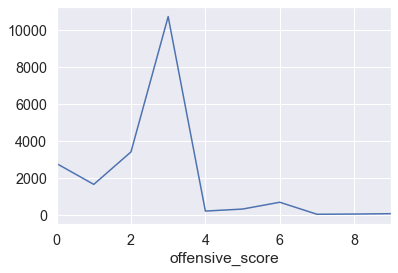

In [47]:
df_train.groupby("offensive_score").count()['text'].plot()

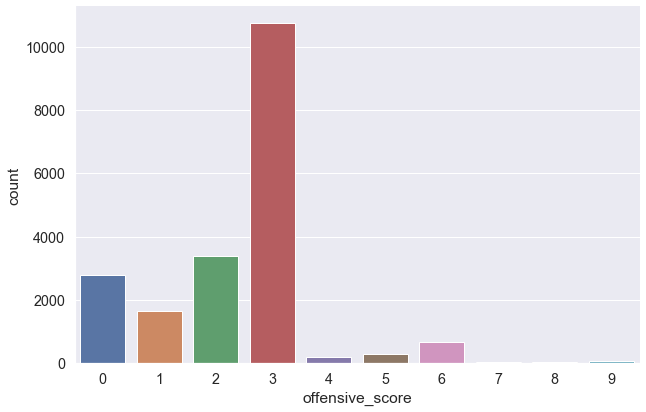

In [99]:
sns.catplot(x="offensive_score", data=df_train, kind="count", height=6, aspect=1.5) # , palette="PuBuGn_d")
plt.show();

# Visualize most frequent words

In [92]:
word = Counter()
for i, row in df_train.iterrows():
    for w in re.split(r'(\d+|\W+)', row["text"].lower()):
        word[w] += 1

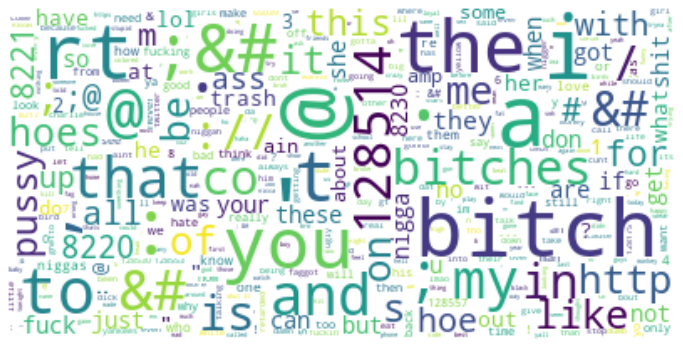

In [93]:
wc = WordCloud(background_color="white", max_words=1000)
wc.generate_from_frequencies(word)
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

# Define Stoppwords

# Make cleaning and enrichment

This enrich_df function can be used for preprocess train and test data

In [76]:
def add_space(text):
    sentence = re.sub(r'(&#\d+;)', r' \1 ', text)
    #emojis= [w for w in re.sub(r"&#\d+;", r"\s&#\d+;\s", text)]  
    sentence = re.sub(r'(@[a-zA-Z0-9_:]+)', r' \1 ', sentence)
    return sentence

t = "a bitch got 8 &amp; I'm trinna@EvanBecker513 change 2 &#128514;&#128557;"
print(add_space(t))


a bitch got 8 &amp; I'm trinna @EvanBecker513  change 2  &#128514;  &#128557; 


In [77]:
# Word tokenization
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords_en
#for w in ["to", "of", "as"]:
#    spacy_stopwords_en.add(w)

# Load English tokenizer, tagger, parser, NER and word vectors
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()

REPLACE_NAMES = re.compile(r"@[a-zA-Z0-9_:]+")
# re.findall(r"@[a-zA-Z0-9_]+", row['text']
REPLACE_EMOJIS = re.compile(r"&#\d+;")
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]/]")
REPLACE_URL = re.compile('http.?://[^\s]+[\s]?')

def remove_stop_words(text):        
    #Implementation of stop words:
    filtered_sent=[]
    #  "nlp" Object is used to create documents with linguistic annotations.
    doc = nlp(text)
    # filtering stop words
    for word in doc:
        if word.is_stop==False:
            filtered_sent.append(str(word))
    text_neu = ' '.join(filtered_sent)
    return text_neu
    

def preprocess_text(reviews):
    reviews = REPLACE_NAMES.sub(" ", reviews) 
    reviews = reviews.replace("RT ", " " ) 
    reviews = REPLACE_URL.sub("", reviews)
    reviews = REPLACE_EMOJIS.sub( " ", reviews.lower()) 
    reviews = REPLACE_NO_SPACE.sub("", reviews)
    reviews = re.sub('\s{2,}', ' ', reviews)
    return reviews

def add_space(text):
    sentence = re.sub(r'(&#\d+;)', r' \1 ', text)
    sentence = re.sub(r'(@[a-zA-Z0-9_:]+)', r' \1 ', sentence)
    return sentence

def get_emoji(row):
    l = re.findall(r"&#(\d+);", row['text'])
    return ' '.join(l)

def enrich_df(df):
    df['names']= df.apply(lambda row: ' '.join([w for w in re.findall(r"@[a-zA-Z0-9_]+", row['text'])]), axis=1)
    df['emoji']= df.apply(lambda row: ' '.join([html.unescape(w) for w in re.findall(r"&#\d{6};", row['text'])]), axis=1)                             
    df['length']= df.apply(lambda row: len(row['text']), axis=1)
    df['RT']= df.apply(lambda row: 1 if 'RT' in row['text']  else 0, axis=1)
    df['text_preprocessed'] = df.apply(lambda row: preprocess_text(row["text"]), axis=1)
    df['clean_stopp'] = df.apply(lambda row: remove_stop_words(row["text_preprocessed"]), axis=1)
    df['with_space'] = df.apply(lambda row: add_space(row["text"]), axis=1)
    return df


In [78]:
enriched_train_df = enrich_df(df_train)
enriched_train_df.head()

,hate_score,offensive_score,text,names,emoji,length,RT,text_preprocessed,clean_stopp,with_space
0,0,0,"Alarm set, early bird n all that. Night all xx",,,46,0,alarm set early bird n all that night all xx,alarm set early bird n night xx,"Alarm set, early bird n all that. Night all xx"
1,1,2,@EvanBecker513 @_TriggaPlease_ @MorbidMermaid @zooyorkinit @_ShayisdaBOMB_ @Rainbowblake they can see this dumbass nigger,@EvanBecker513 @_TriggaPlease_ @MorbidMermaid @zooyorkinit @_ShayisdaBOMB_ @Rainbowblake,,121,0,they can see this dumbass nigger,dumbass nigger,@EvanBecker513 @_TriggaPlease_ @MorbidMermaid @zooyorkinit @_ShayisdaBOMB_ @Rainbowblake they can see this dumbass nigger
2,0,3,RT @_MindAtEase: Wet pussy with no smell a mf,@_MindAtEase,,45,1,wet pussy with no smell a mf,wet pussy smell mf,RT @_MindAtEase: Wet pussy with no smell a mf
3,0,3,"RT @itsSamCollins: I hate seeing people with money spend it on stupid shit, you don't need 11 TVs &amp; a shark tank you twat",@itsSamCollins,,125,1,i hate seeing people with money spend it on stupid shit you dont need 11 tvs &amp a shark tank you twat,hate seeing people money spend stupid shit nt need 11 tvs & amp shark tank twat,"RT @itsSamCollins: I hate seeing people with money spend it on stupid shit, you don't need 11 TVs &amp; a shark tank you twat"
4,0,3,&#8220;@RawrItsTaraa: Trust these bitches ? Nah&#8221;,@RawrItsTaraa,,54,0,trust these bitches nah,trust bitches nah,&#8220; @RawrItsTaraa: Trust these bitches ? Nah &#8221;


# Most frequent words in preprocessed data

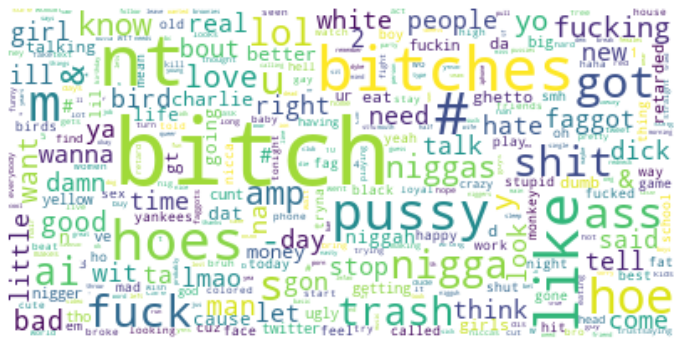

In [30]:
word = Counter()
for i, row in enriched_train_df.iterrows():
    for w in re.split(r'(\d+|\W+)', row["clean_stopp"].lower()):
        word[w] += 1
        
wc = WordCloud(background_color="white", max_words=1000)
wc.generate_from_frequencies(word)
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

In [31]:
word_counter = Counter()
for i, row in df_train.iterrows():
    for w in re.findall(r"&#\d{6};", row['text'].lower()):
        word_counter[html.unescape(w)] += 1
word_counter.most_common(10)

[('😂', 2582),
 ('😭', 489),
 ('😩', 302),
 ('💯', 260),
 ('😒', 214),
 ('😍', 149),
 ('💀', 138),
 ('😴', 95),
 ('👏', 95),
 ('😏', 94)]

In [32]:
enriched_train_df['emoji'].value_counts()

                           17033
😂                            237
😂 😂 😂                        147
😂 😂                          136
😒                             98
                           ...  
😒 😳 👐                          1
😭 😭 😭 😭 😭 😭 😭 😭 😭 😭 😭 😭        1
😛 😺 💦 💦                        1
😡 😡 😡 😂                        1
😎 👌                            1
Name: emoji, Length: 1112, dtype: int64

# Create hate_df and offensive_df based on score

In [33]:
filter = enriched_train_df["offensive_score"]>4

offensive_df = enriched_train_df[filter]
offensive_df[["text","offensive_score"]].head()

,text,offensive_score
8,Happy birthday little bitch boy @Digo13Nieto &...,6
10,RT @vinnycrack: this bitch got the itunes term...,9
42,RT @TIKOAMG: Social network got bitches heads ...,6
61,@_Aly_baby_ well at least If you're going to d...,6
74,@TinnyTimm taylor wack ass bitch nigga,5


In [34]:
filter2 = enriched_train_df["hate_score"]>3

hates_df = enriched_train_df[filter2]
hates_df[["text","hate_score"]].head()

,text,hate_score
764,She got every niggah lookin like dam,4
1111,Chris Bosh bout to disgrace the trophy like a ...,4
2168,I hate fat bitches,7
2893,RT @DefendWallSt: Tell me how you really feel....,5
2926,RT @SwaaggyyV: Fucking chinks in Clash of Clan...,5


In [35]:
offensive_df.shape

(1084, 9)

In [36]:
hates_df.shape

(29, 9)

# The most frequent emojis in offensive data

In [37]:
word_counter = Counter()
for i, row in offensive_df.iterrows():
    for w in re.findall(r"&#\d{6};", row['text'].lower()):
        word_counter[html.unescape(w)] += 1
word_counter.most_common(10)

[('😂', 217),
 ('😭', 25),
 ('💯', 24),
 ('😩', 20),
 ('😍', 16),
 ('👐', 15),
 ('😡', 15),
 ('👀', 14),
 ('😒', 13),
 ('😳', 12)]

# The most frequent emojis in hate data

In [38]:
word_counter = Counter()
for i, row in hates_df.iterrows():
    for w in re.findall(r"&#\d{6};", row['text'].lower()):
        word_counter[html.unescape(w)] += 1
word_counter.most_common(10)

[]

In [39]:
hates_df.emoji.value_counts()

    29
Name: emoji, dtype: int64

## The most frequent words in hates

In [40]:
text_word = Counter()
for i, row in hates_df.iterrows():
    for w in re.split(r'(\d+|\W+)', row['text_preprocessed']):
        if (w != " ") and (w!= "") and (w!="  ") and (len(w)>2) and (w!="the"):
            text_word[w] += 1
text_word.most_common(50)

[('fuck', 4),
 ('bitch', 4),
 ('amp', 4),
 ('hoes', 4),
 ('like', 3),
 ('faggot', 3),
 ('you', 3),
 ('have', 3),
 ('dont', 3),
 ('whitey', 3),
 ('all', 3),
 ('blame', 3),
 ('that', 3),
 ('nigga', 3),
 ('niggah', 2),
 ('hate', 2),
 ('tell', 2),
 ('how', 2),
 ('feel', 2),
 ('little', 2),
 ('faggots', 2),
 ('fucking', 2),
 ('always', 2),
 ('ass', 2),
 ('ever', 2),
 ('never', 2),
 ('even', 2),
 ('seen', 2),
 ('and', 2),
 ('trash', 2),
 ('with', 2),
 ('these', 2),
 ('fuckin', 2),
 ('who', 2),
 ('hope', 2),
 ('one', 2),
 ('fag', 2),
 ('when', 2),
 ('muslims', 2),
 ('are', 2),
 ('cant', 2),
 ('nowhere', 2),
 ('your', 2),
 ('she', 1),
 ('got', 1),
 ('every', 1),
 ('lookin', 1),
 ('dam', 1),
 ('chris', 1),
 ('bosh', 1)]

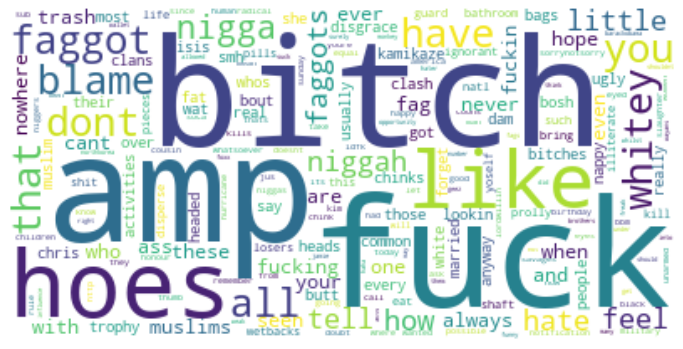

In [41]:
wc.generate_from_frequencies(text_word)
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

## The most frequent words in offensive

In [42]:
text_word = Counter()
for i, row in offensive_df.iterrows():
    for w in re.split(r'(\d+|\W+)', row['text_preprocessed']):
        if (w != " ") and (w!= "") and (w!="  ") and (len(w)>2) and (w!="the") and (w!="and") and (w!="that") \
        and (w!="this") and (w!="these"):
            text_word[w] += 1
text_word.most_common(50)

[('bitch', 492),
 ('you', 270),
 ('bitches', 190),
 ('hoes', 161),
 ('hoe', 124),
 ('like', 119),
 ('got', 94),
 ('pussy', 93),
 ('dont', 85),
 ('all', 82),
 ('for', 76),
 ('with', 75),
 ('they', 73),
 ('ass', 72),
 ('aint', 72),
 ('she', 69),
 ('her', 68),
 ('fuck', 68),
 ('shit', 62),
 ('but', 61),
 ('just', 60),
 ('when', 59),
 ('get', 57),
 ('niggah', 55),
 ('your', 54),
 ('nigga', 52),
 ('out', 50),
 ('lol', 42),
 ('its', 41),
 ('not', 41),
 ('know', 41),
 ('niggas', 37),
 ('was', 37),
 ('some', 37),
 ('bad', 35),
 ('have', 35),
 ('them', 33),
 ('about', 32),
 ('love', 32),
 ('how', 31),
 ('yall', 30),
 ('can', 29),
 ('cant', 29),
 ('amp', 28),
 ('need', 28),
 ('his', 27),
 ('now', 27),
 ('really', 26),
 ('what', 26),
 ('one', 26)]

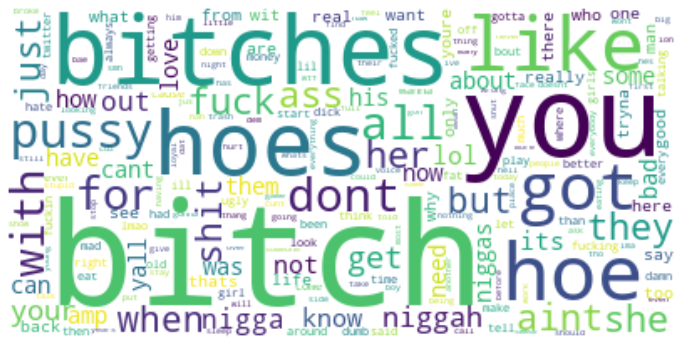

In [43]:
wc.generate_from_frequencies(text_word)
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

# Create a class TextCounts To analyze the text variable

In [44]:
pd.set_option('display.max_colwidth', -1)

import collections
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
import warnings
warnings.filterwarnings('ignore')

class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        text_length = X.apply(lambda x: len(x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: self.count_regex(r"&#\d{6};", x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                           , 'text_length': text_length
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df_train.text)
#df_eda.head()
df_eda['hate_score'] = df_train.hate_score
df_eda['offensive_score'] = df_train.offensive_score

In [45]:
def show_dist(df, group_col, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby(group_col)[col].describe())
    #bins = np.arange(df[col].min(), df[col].max() + 1)
    #g = sns.FacetGrid(df, col=group_col, size=5, hue=group_col, palette="PuBuGn_d")
    #g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    #plt.show()

In [46]:
show_dist(df_eda, 'hate_score', 'text_length')

Descriptive stats for text_length
---------------------------------
              count       mean        std   min    25%   50%     75%    max
hate_score                                                                 
0           15788.0  83.370851  41.063499  4.0   50.00  78.0  116.00  657.0
1           2767.0   83.575352  40.766198  6.0   49.00  81.0  119.00  277.0
2           1000.0   81.300000  41.037276  9.0   45.00  77.0  119.00  254.0
3           242.0    85.413223  39.682280  10.0  50.00  84.0  123.00  170.0
4           18.0     68.777778  41.667529  3.0   38.75  63.0  101.00  143.0
5           6.0      90.666667  27.383693  53.0  79.00  92.5  94.75   136.0
6           3.0      98.333333  51.500809  47.0  72.50  98.0  124.00  150.0
7           2.0      66.500000  68.589358  18.0  42.25  66.5  90.75   115.0


In [47]:
show_dist(df_eda, 'offensive_score', 'text_length')

Descriptive stats for text_length
---------------------------------
                   count       mean        std   min   25%   50%     75%  \
offensive_score                                                            
0                2772.0   91.606782  40.743724  3.0   58.0  92.0  130.00   
1                1641.0   85.429616  41.373095  8.0   50.0  84.0  122.00   
2                3401.0   83.800647  40.566840  7.0   49.0  81.0  118.00   
3                10734.0  81.282094  40.837781  4.0   49.0  75.0  111.00   
4                194.0    78.680412  37.608026  13.0  51.0  69.0  105.75   
5                304.0    78.792763  42.214521  9.0   46.0  73.5  108.25   
6                673.0    79.545319  41.944494  7.0   47.0  72.0  108.00   
7                21.0     63.571429  40.316959  9.0   26.0  55.0  82.00    
8                33.0     75.818182  43.777459  11.0  37.0  71.0  118.00   
9                53.0     65.886792  31.754261  10.0  41.0  66.0  81.00    

                   

In [48]:
show_dist(df_eda, 'offensive_score', 'count_emojis')

Descriptive stats for count_emojis
----------------------------------
                   count      mean       std  min  25%  50%  75%   max
offensive_score                                                       
0                2772.0   0.151154  0.680094  0.0  0.0  0.0  0.0  11.0
1                1641.0   0.184644  0.842127  0.0  0.0  0.0  0.0  15.0
2                3401.0   0.310203  1.115893  0.0  0.0  0.0  0.0  22.0
3                10734.0  0.433296  1.621151  0.0  0.0  0.0  0.0  65.0
4                194.0    0.376289  1.085779  0.0  0.0  0.0  0.0  7.0 
5                304.0    0.450658  1.241818  0.0  0.0  0.0  0.0  11.0
6                673.0    0.583952  1.602410  0.0  0.0  0.0  0.0  20.0
7                21.0     0.428571  1.121224  0.0  0.0  0.0  0.0  4.0 
8                33.0     0.212121  0.545297  0.0  0.0  0.0  0.0  2.0 
9                53.0     0.433962  1.184993  0.0  0.0  0.0  0.0  5.0 


In [49]:
show_dist(df_eda, 'hate_score', 'count_emojis')

Descriptive stats for count_emojis
----------------------------------
              count      mean       std  min  25%  50%  75%   max
hate_score                                                       
0           15788.0  0.382062  1.461731  0.0  0.0  0.0  0.0  65.0
1           2767.0   0.294181  1.048798  0.0  0.0  0.0  0.0  22.0
2           1000.0   0.194000  0.872425  0.0  0.0  0.0  0.0  15.0
3           242.0    0.123967  0.612054  0.0  0.0  0.0  0.0  5.0 
4           18.0     0.000000  0.000000  0.0  0.0  0.0  0.0  0.0 
5           6.0      0.000000  0.000000  0.0  0.0  0.0  0.0  0.0 
6           3.0      0.000000  0.000000  0.0  0.0  0.0  0.0  0.0 
7           2.0      0.000000  0.000000  0.0  0.0  0.0  0.0  0.0 


In [50]:

df_eda.groupby("hate_score")['count_emojis'].mean()

hate_score
0    0.382062
1    0.294181
2    0.194000
3    0.123967
4    0.000000
5    0.000000
6    0.000000
7    0.000000
Name: count_emojis, dtype: float64

In [51]:
df_eda[df_eda['count_emojis']==65]

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,text_length,hate_score,offensive_score
1099,78,0,65,0,7,0,65,657,0,3
